# 3. Fitting models to data

In this workbook we will import data and find the cosmological model that best fits that data. 

### 3.1 First set up the packages and functions
We need to know the distance modulus as a function of redshift.  Distance modulus is defined as 
\begin{equation} \mu(z) = 5 \log_{10}(D_L)\end{equation}
where
\begin{equation} D_L = R_0 S_k(\chi) (1+z) \end{equation}
and $S_k(\chi)=\sin(\chi), \chi,\; {\rm or}\; \sinh(\chi)$ for closed, flat, and open universes respectively, and
\begin{equation} R_0\chi = \frac{c}{H_0}\int_0^z \frac{dz}{E(z)}\end{equation}
with $E(z)=H(z)/H_0$.

Note that the absolute magnitude of the SNe is about -19.5, but it enters as an additive constant in the same way as $c/H_0$ and both have high uncertainty.  Therefore we *marginalise* over this offset and it doesn't matter what value of $H_0$ we use.

#### Important: In the code below, replace ez = 1.0 with the actual function for E(z).


In [1]:
# First let's set up our packages
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate
import math
# And set some constants
c = 299792.458 # km/s (speed of light)
H0kmsmpc = 70.  # Hubble constant in km/s/Mpc
H0s = H0kmsmpc * 3.2408e-20 # H0 in inverse seconds is H0 in km/s/Mpc * (3.2408e-20 Mpc/km)

# Write a function for the integrand, i.e. $1/E(z)$,
def ezinv(z, om=0.3, orr=0.0, ol=0.7, w0=-1.0, wa=0.0):
    # ok = 1.-om-orr-ol
    power_for_ol = 3*(1+w0+(wa*(1-(1/(1+z)))))
    ez = np.sqrt((orr*(1+z)**4) + (om*(1+z)**3) + ((1.0-om-ol-orr)*(1+z)**2) + (ol*((1+z)**(power_for_ol))))
    return 1./ez

# The curvature correction function
def Sk(xx, ok):
    if ok < 0.0:
        dk = np.sin(np.sqrt(-ok)*xx)/np.sqrt(-ok)
    elif ok > 0.0:
        dk = np.sinh(np.sqrt(ok)*xx)/np.sqrt(ok)
    else:
        dk = xx
    return dk

# The distance modulus
def dist_mod(zs, om=0.3, orr=0.0, ol=0.7, w0=-1.0, wa=0.0):
    """ Calculate the distance modulus, correcting for curvature"""
    ok = 1.0 - om - orr - ol
    xx = np.array([integrate.quad(ezinv, 0, z, args=(om, orr, ol, w0, wa))[0] for z in zs])
    D = Sk(xx, ok)
    lum_dist = D * (1 + zs) 
    dist_mod = 5 * np.log10(lum_dist) # Distance modulus
    # Add an arbitrary constant that's approximately the log of c on Hubble constant minus absolute magnitude of -19.5
    # dist_mod = dist_mod + np.log(c/H0kmsmpc)-(-19.5)  # You can actually skip this step and it won't make a difference to our fitting
    return dist_mod

# The distance modulus
def dist_mod_test(zs, om=0.3, orr=0.0, ol=0.7, w0=-1.0, wa=0.0):
    """ Calculate the distance modulus, correcting for curvature"""
    ok = 1.0 - om - orr - ol
    keypoints = np.linspace(0.0,max(zs),100)
    xxkey = np.array([integrate.quad(ezinv, 0, z, args=(om, orr, ol, w0, wa))[0] for z in keypoints])
    xx = np.ones([len(zs)])
    for i, z in enumerate(zs):
        closeind = np.argmin(abs(z*np.ones([100]) - keypoints))
        closexxkey = xxkey[closeind]
        closez = keypoints[closeind] 
        if closez < z:
            g = ((xxkey[closeind+1] - closexxkey)/(keypoints[closeind+1] - closez)) 
            a = (closexxkey-(g*closez))
            xx[i] = g*z + a
        elif closez > z:
            g = ((closexxkey - xxkey[closeind-1] )/(closez - keypoints[closeind-1])) 
            a = (closexxkey-(g*closez))
            xx[i] = g*z + a
        else:
            xx[i] = closexxkey
    D = Sk(xx, ok)
    lum_dist = D * (1 + zs) 
    dist_mod = 5 * np.log10(lum_dist) # Distance modulus
    # Add an arbitrary constant that's approximately the log of c on Hubble constant minus absolute magnitude of -19.5
    # dist_mod = dist_mod + np.log(c/H0kmsmpc)-(-19.5)  # You can actually skip this step and it won't make a difference to our fitting
    return dist_mod




In [2]:
w0=-1.0
wa=0.0
3*(1+w0+(wa*(1-(1/(1+2)))))

0.0

### 3.2 Now read in the data
I have generated some mock supernova data at random redshifts between $0.02<z<1.0$.  I then choose a cosmological model and calculate the distance modulus for each redshift in that model.  Then I give some uncertainty to the data points and scatter them randomly about the correct model by an amount corresponding to their uncertainty. 

I've generated 5 different models, all in files called DataX.txt, where X is a number from 0-4. 

There are five possible variables that I have specified in the models.  These are
* Matter density: $\Omega_M$
* Dark Energy density: $\Omega_\Lambda$
* Radiation density: $\Omega_R$
* Equation of state of dark energy: $w_0$
* Change in the equation of state with scalefactor: $w_a$, where $w=w_0+w_a(1-a)$.

You can test your code on Data00.txt and Data0.txt.  Both were generated using a model with $(\Omega_M,\Omega_{\Lambda})=(0.3,0.7)$ and all other parameters set to their standard values, namely $\Omega_R=0.0$, $w_0=-1.0$, $w_a=0.0$.  In addition Data00.txt has perfect data with no scatter and small uncertainties, so you should be able to recover exactly the correct model. 

Data sets 1-2 are models in which $\Omega_R=0.0$, $w_0=-1.0$, $w_a=0.0$ and only $\Omega_M$ and $\Omega_{\Lambda}$ change.  

Data sets 3-4 could be anything! (Within the realms of the five parameters described above.)

Feel free to choose which data set you want to analyse for your project.


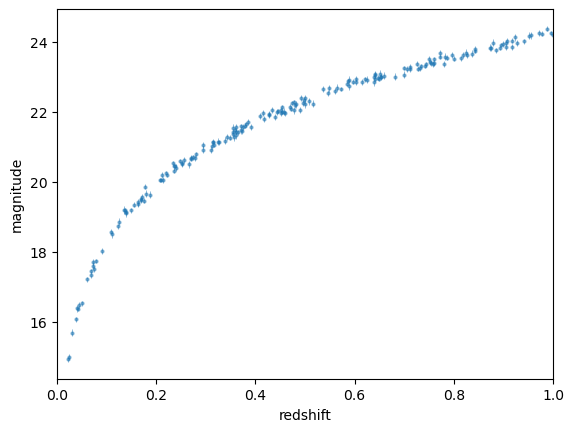

In [3]:
# Add a new function that reads in the data (data files should be in a directory called data)
def read_data(model_name):
    d = np.genfromtxt('data/'+model_name+'.txt',delimiter=',')
    zs = d[:,0]
    mu = d[:,1]
    muerr=d[:,2]
    return zs, mu, muerr

zs, mu, muerr = read_data('Data1')

# Plot it to see what it looks like, this is called a Hubble diagram
plt.errorbar(zs,mu,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
plt.xlim(0,1.0)
plt.xlabel('redshift')
plt.ylabel('magnitude')
plt.show()


### 3.3 Calculate the theory corresponding to that data for a range of cosmological models
Then overplot them on the Hubble diagram.  Here we're just testing some specific interesting examples.
It's always important to visualise your data and check that the models and data are doing what you think they are!

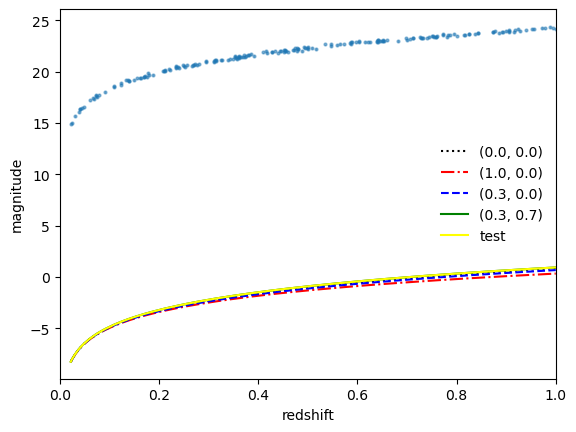

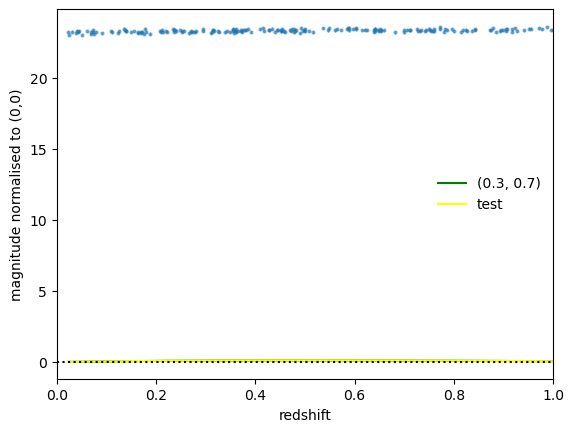

In [4]:
mu_om00_ox00 = dist_mod(zs,om=0.0,ol=0.0)  # We're going to use this empty model as a benchmark to compare the others to
mu_om10_ox00 = dist_mod(zs,om=1.0,ol=0.0)
mu_om03_ox00 = dist_mod(zs,om=0.3,ol=0.0)
mu_om03_ox07 = dist_mod(zs,om=0.3,ol=0.7)
test = dist_mod_test(zs,om=0.3,ol=0.7)

# Plot it to see what it looks like, this is called a Hubble diagram
plt.errorbar(zs,mu,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
plt.plot(zs,mu_om00_ox00,':',color='black',label='(0.0, 0.0)')
plt.plot(zs,mu_om10_ox00,'-.',color='red',label='(1.0, 0.0)')
plt.plot(zs,mu_om03_ox00,'--',color='blue',label='(0.3, 0.0)')
plt.plot(zs,mu_om03_ox07,'-',color='green',label='(0.3, 0.7)')
plt.plot(zs,test,'-',color='yellow',label='test')
plt.xlim(0,1.0)
plt.xlabel('redshift')
plt.ylabel('magnitude')
plt.legend(frameon=False)
plt.show()

# Now plot a Hubble diagram relative to the empty model (i.e. subtract the empty model from all the data and models)
plt.errorbar(zs,mu-mu_om00_ox00,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
# plt.plot(zs,mu_om10_ox00-mu_om00_ox00,'-.',color='red',label='(1.0, 0.0)')
# plt.plot(zs,mu_om03_ox00-mu_om00_ox00,'--',color='blue',label='(0.3, 0.0)')
plt.plot(zs,mu_om03_ox07-mu_om00_ox00,'-',color='green',label='(0.3, 0.7)')
plt.plot(zs,test-mu_om00_ox00,'-',color='yellow',label='test')
plt.axhline(y=0.0,ls=':',color='black')
plt.xlim(0.0,1.0)
plt.xlabel('redshift')
plt.ylabel('magnitude normalised to (0,0)')
plt.legend(frameon=False)
plt.show()

### 3.4 Normalise the theory
You can see that there is a vertical offset between the different theory curves.  
We marginalise over this vertical offset, because we do not have enough information to constrain the vertical offset independently.
In other words we use the data to determine what the vertical offset should be, but we do not care about what the answer is!
(We are interested in the other parameters in the fit, but not that one.  The other parameters determine the *shape* of the curve.)

The easiest way to normalise the curves is to take a weighted average of the difference between the data points and the theory in each case.

-23.560674297134412 -23.390794679460754 -23.206256166105373


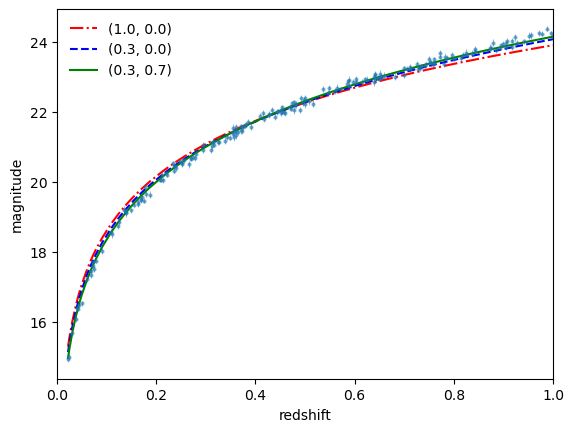

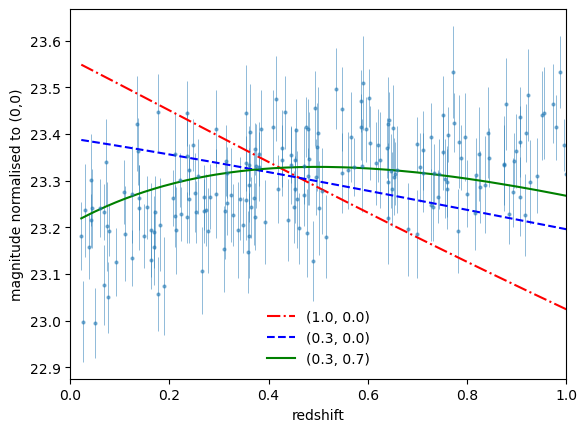

In [5]:
# Calculate mscript for each of these, which is the thing that determines the vertical normalisation 
mscr_om10_ox00 = np.sum((mu_om10_ox00-mu)/muerr**2)/np.sum(1./muerr**2)
mscr_om03_ox00 = np.sum((mu_om03_ox00-mu)/muerr**2)/np.sum(1./muerr**2)
mscr_om03_ox07 = np.sum((mu_om03_ox07-mu)/muerr**2)/np.sum(1./muerr**2)

print(mscr_om10_ox00,mscr_om03_ox00,mscr_om03_ox07)

mu_om10_ox00=mu_om10_ox00-mscr_om10_ox00
mu_om03_ox00=mu_om03_ox00-mscr_om03_ox00
mu_om03_ox07=mu_om03_ox07-mscr_om03_ox07

# Repeat the plot and see how it changes
# Plot it to see what it looks like, this is called a Hubble diagram
plt.errorbar(zs,mu,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
plt.plot(zs,mu_om10_ox00,'-.',color='red',label='(1.0, 0.0)')
plt.plot(zs,mu_om03_ox00,'--',color='blue',label='(0.3, 0.0)')
plt.plot(zs,mu_om03_ox07,'-',color='green',label='(0.3, 0.7)')
plt.xlim(0,1.0)
plt.xlabel('redshift')
plt.ylabel('magnitude')
plt.legend(frameon=False)
plt.show()

# Now plot a Hubble diagram relative to the empty model (i.e. subtract the empty model from all the data and models)
plt.errorbar(zs,mu-mu_om00_ox00,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
plt.plot(zs,mu_om10_ox00-mu_om00_ox00,'-.',color='red',label='(1.0, 0.0)')
plt.plot(zs,mu_om03_ox00-mu_om00_ox00,'--',color='blue',label='(0.3, 0.0)')
plt.plot(zs,mu_om03_ox07-mu_om00_ox00,'-',color='green',label='(0.3, 0.7)')
# plt.axhline(y=0.0,ls=':',color='black')
plt.xlim(0,1.0)
plt.xlabel('redshift')
plt.ylabel('magnitude normalised to (0,0)')
plt.legend(frameon=False)
plt.show()

## 3.5 Perform a fit to many models 
To find the best model that best matches the data use a $\chi^2$ test.


In [6]:
# Set up the arrays for the models you want to test, e.g. a range of Omega_m and Omega_Lambda models:
n = 21                         # Increase this for a finer grid
oms = np.linspace(0.0, 0.5, n)   # Array of matter densities
ols = np.linspace(0.0, 1.0, n)   # Array of cosmological constant values
chi2 = np.ones((n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values

# Calculate Chi2 for each model
for i, om in enumerate(oms):                                          # loop through matter densities
        for j, ol in enumerate(ols):                                  # loop through cosmological constant densities
            mu_model = dist_mod_test(zs, om=om, ol=ol)                     # calculate the distance modulus vs redshift for that model 
            mscr = np.sum((mu_model-mu)/muerr**2)/np.sum(1./muerr**2) # Calculate the vertical offset to apply
            mu_model_norm = mu_model-mscr                             # Apply the vertical offset
            chi2[i,j] = np.sum((mu_model_norm - mu) ** 2 / muerr**2)  # Calculate the chi2 and save it in a matrix
            
# Convert that to a likelihood and calculate the reduced chi2
likelihood = np.exp(-0.5 * (chi2-np.amin(chi2)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
chi2_reduced = chi2 / (len(mu)-2)                 # calculate the reduced chi^2, i.e. chi^2 per degree of freedom, where dof = number of data points minus number of parameters being fitted 

# Calculate the best fit values (where chi2 is minimum)
indbest = np.argmin(chi2)                 # Gives index of best fit but where the indices are just a single number
ibest   = np.unravel_index(indbest,[n,n]) # Converts the best fit index to the 2d version (i,j)
print( 'Best fit values are (om,ol)=(%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]] ) )
print( 'Reduced chi^2 for the best fit is %0.2f'%chi2_reduced[ibest[0],ibest[1]] )
print('likelihood = ',likelihood[ibest[0],ibest[1]])


# # Uncomment this code and comment the previous if doing a grid search with three parameters: om, orr, and ol.
# # Set up the arrays for the models you want to test, e.g. a range of Omega_m and Omega_Lambda models:
# n = 25                        # Increase this for a finer grid
# oms = np.linspace(0.0, 0.5, n)   # Array of matter densities
# ols = np.linspace(0.0, 1, n)   # Array of cosmological constant values
# orrs = np.linspace(0.0, 1.0, n)  # Array of radiation densities
# chi2 = np.ones((n, n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values

# # Calculate Chi2 for each model
# for i, om in enumerate(oms):                                          # loop through matter densities
#         for j, ol in enumerate(ols):
#                 for k, orr in enumerate(orrs):                              # loop through cosmological constant densities
#                     mu_model = dist_mod(zs, om=om, orr=orr, ol=ol)                     # calculate the distance modulus vs redshift for that model 
#                     mscr = np.sum((mu_model-mu)/muerr**2)/np.sum(1./muerr**2) # Calculate the vertical offset to apply
#                     mu_model_norm = mu_model-mscr                             # Apply the vertical offset
#                     chi2[i,j,k] = np.sum((mu_model_norm - mu) ** 2 / muerr**2)  # Calculate the chi2 and save it in a matrix
            
# # Convert that to a likelihood and calculate the reduced chi2
# # likelihood = np.exp(-0.5 * (chi2-np.amin(chi2)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
# chi2_reduced = chi2 / (len(mu)-3)                 # calculate the reduced chi^2, i.e. chi^2 per degree of freedom, where dof = number of data points minus number of parameters being fitted 

# # Calculate the best fit values (where chi2 is minimum)
# indbest = np.argmin(chi2)                 # Gives index of best fit but where the indices are just a single number
# ibest   = np.unravel_index(indbest,[n,n,n]) # Converts the best fit index to the 3d version (i,j,k)
# print( 'Best fit values are (om,ol,orr)=(%.3f,%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]], orrs[ibest[2]] ) )
# print( 'Reduced chi^2 for the best fit is %0.2f'%chi2_reduced[ibest[0],ibest[1],ibest[2]] )
# # print('likelihood = ',likelihood[ibest[0],ibest[1]])



# # Uncomment this code and comment the previous if doing a grid search with three parameters: om, ol, and wa
# # Set up the arrays for the models you want to test, e.g. a range of Omega_m and Omega_Lambda models:
# n = 25                        # Increase this for a finer grid
# oms = np.linspace(0.0, 0.5, n)   # Array of matter densities
# ols = np.linspace(0.0, 1.0, n)   # Array of cosmological constant values
# was = np.linspace(0.0, 1.0, n)  # Array of changes in equation of state
# chi2 = np.ones((n, n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values

# # Calculate Chi2 for each model
# for i, om in enumerate(oms):                                          # loop through matter densities
#         for j, ol in enumerate(ols):
#                 for k, wa in enumerate(was):                              # loop through cosmological constant densities
#                     mu_model = dist_mod(zs, om=om, wa=wa, ol=ol)                     # calculate the distance modulus vs redshift for that model 
#                     mscr = np.sum((mu_model-mu)/muerr**2)/np.sum(1./muerr**2) # Calculate the vertical offset to apply
#                     mu_model_norm = mu_model-mscr                             # Apply the vertical offset
#                     chi2[i,j,k] = np.sum((mu_model_norm - mu) ** 2 / muerr**2)  # Calculate the chi2 and save it in a matrix
            
# # Convert that to a likelihood and calculate the reduced chi2
# # likelihood = np.exp(-0.5 * (chi2-np.amin(chi2)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
# chi2_reduced = chi2 / (len(mu)-3)                 # calculate the reduced chi^2, i.e. chi^2 per degree of freedom, where dof = number of data points minus number of parameters being fitted 

# # Calculate the best fit values (where chi2 is minimum)
# indbest = np.argmin(chi2)                 # Gives index of best fit but where the indices are just a single number
# ibest   = np.unravel_index(indbest,[n,n,n]) # Converts the best fit index to the 3d version (i,j,k)
# print( 'Best fit values are (om,ol,wa)=(%.3f,%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]], was[ibest[2]] ) )
# print( 'Reduced chi^2 for the best fit is %0.2f'%chi2_reduced[ibest[0],ibest[1],ibest[2]] )
# # print('likelihood = ',likelihood[ibest[0],ibest[1]])


# ##### THIS WILL TAKE A LOOOOOOOONNNG TIME TO RUN.
# # Uncomment this code and comment the previous if doing a grid search with three parameters: om, ol, orr, wa, and w0
# # Set up the arrays for the models you want to test, e.g. a range of Omega_m and Omega_Lambda models:
# n = 10                        # Increase this for a finer grid
# oms = np.linspace(0.0, 0.4, n)   # Array of matter densities
# ols = np.linspace(0.0, 0.4, n)   # Array of cosmological constant values
# was = np.linspace(0.0, 0.5, n)  # Array of changes in equation of state
# orrs = np.linspace(0.0, 0.25, n) # array of radiation densities
# w0s = np.linspace(-1.5, -1.0, n)
# chi2 = np.ones((n, n, n, n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values

# # Calculate Chi2 for each model
# for i, om in enumerate(oms):    # loop through matter densities                                   
#         for j, ol in enumerate(ols):    # loop through cosmological constant densities
#                 for k, wa in enumerate(was):    # loop through changes in equation of state
#                                 for l, orr in enumerate(orrs):     # loop through radiation densities       
#                                                 for m, w0 in enumerate(w0s):                
#                                                         mu_model = dist_mod(zs, om=om, wa=wa, ol=ol, orr=orr, w0=w0)                     # calculate the distance modulus vs redshift for that model 
#                                                         mscr = np.sum((mu_model-mu)/muerr**2)/np.sum(1./muerr**2) # Calculate the vertical offset to apply
#                                                         mu_model_norm = mu_model-mscr                             # Apply the vertical offset
#                                                         chi2[i,j,k,l,m] = np.sum((mu_model_norm - mu) ** 2 / muerr**2)  # Calculate the chi2 and save it in a matrix
            
# # Convert that to a likelihood and calculate the reduced chi2
# # likelihood = np.exp(-0.5 * (chi2-np.amin(chi2)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
# chi2_reduced = chi2 / (len(mu)-5)                 # calculate the reduced chi^2, i.e. chi^2 per degree of freedom, where dof = number of data points minus number of parameters being fitted 

# # Calculate the best fit values (where chi2 is minimum)
# indbest = np.argmin(chi2)                 # Gives index of best fit but where the indices are just a single number
# ibest   = np.unravel_index(indbest,[n,n,n,n,n]) # Converts the best fit index to the 3d version (i,j,k)
# print( 'Best fit values are (om,ol,wa,orr,w0)=(%.3f,%.3f,%.3f,%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]], was[ibest[2]], orrs[ibest[3]], w0s[ibest[4]] ) )
# print( 'Reduced chi^2 for the best fit is %0.2f'%chi2_reduced[ibest[0],ibest[1],ibest[2],ibest[3],ibest[4]] )
# #For a good fit, the reduced Chi^2 should be close to 1.

Best fit values are (om,ol)=(0.150,0.700)
Reduced chi^2 for the best fit is 1.12
likelihood =  1.0


In [7]:
chi2

array([[319.29658381, 300.96776818, 283.973709  , 268.4816708 ,
        254.68207448, 242.79254444, 233.06284573, 225.78095287,
        221.28057249, 219.95055327, 222.24677537, 228.70733975,
        239.97221323, 256.80898781, 280.14718294, 311.12473222,
        351.15225943, 402.00404043, 465.95028475, 545.95584617,
        645.99069857],
       [336.40199505, 316.88975756, 298.58097637, 281.62602181,
        266.19563704, 252.48440512, 240.71495628, 231.14311012,
        224.06421001, 219.82099295, 218.81345892, 221.5113756 ,
        228.47030367, 240.35239532, 257.95377284, 282.24115004,
        314.40171487, 355.9125093 , 408.63929544, 474.98152047,
        558.09226457],
       [354.78751345, 334.19813207, 314.69311604, 296.40781376,
        279.49553149, 264.1305109 , 250.51152386, 238.86624228,
        229.45658917, 222.58534384, 218.60436664, 217.9249389 ,
        221.03089989, 228.49553355, 241.00355973, 259.38019451,
        284.63019086, 317.99128437, 361.00896273, 415.6437

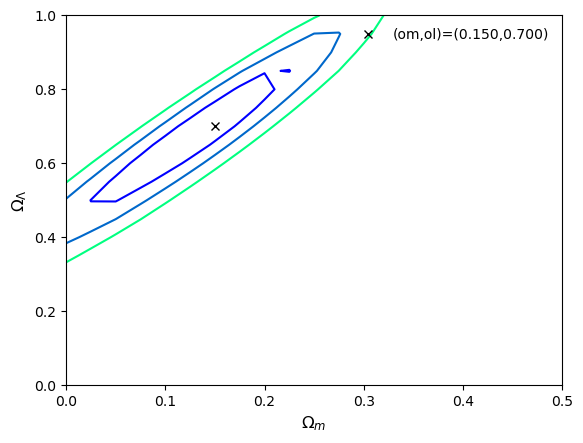

In [8]:
# Use this cell if doing a grid search of two parameters. No 3-parameter version of this yet.
# Plot contours of 1, 2, and 3 sigma
plt.contour(oms,ols,np.transpose(chi2-np.amin(chi2)),cmap="winter",**{'levels':[2.30,6.18,11.83]})
plt.plot(oms[ibest[0]], ols[ibest[1]],'x',color='black',label='(om,ol)=(%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]]) )
plt.xlabel("$\Omega_m$", fontsize=12)
plt.ylabel("$\Omega_\Lambda$", fontsize=12)
# plt.plot([oms[0],oms[1]], [ols[0],ols[1]],'-',color='black',label='Step size indicator' ) # Delete this line after making step size smaller!
plt.legend(frameon=False)
#plt.savefig('plots/contours.png', bbox_inches="tight", transparent=True)
plt.show()
plt.close()


In [9]:
print(chi2-np.amin(chi2))
print(len(chi2))
print(np.sum(np.exp(-0.5 * (chi2))))

[[1.02722432e+02 8.43936165e+01 6.73995573e+01 5.19075191e+01
  3.81079228e+01 2.62183927e+01 1.64886940e+01 9.20680118e+00
  4.70642079e+00 3.37640157e+00 5.67262367e+00 1.21331880e+01
  2.33980615e+01 4.02348361e+01 6.35730312e+01 9.45505805e+01
  1.34578108e+02 1.85429889e+02 2.49376133e+02 3.29381694e+02
  4.29416547e+02]
 [1.19827843e+02 1.00315606e+02 8.20068247e+01 6.50518701e+01
  4.96214853e+01 3.59102534e+01 2.41408046e+01 1.45689584e+01
  7.49005831e+00 3.24684126e+00 2.23930722e+00 4.93722390e+00
  1.18961520e+01 2.37782436e+01 4.13796211e+01 6.56669983e+01
  9.78275632e+01 1.39338358e+02 1.92065144e+02 2.58407369e+02
  3.41518113e+02]
 [1.38213362e+02 1.17623980e+02 9.81189643e+01 7.98336621e+01
  6.29213798e+01 4.75563592e+01 3.39373722e+01 2.22920906e+01
  1.28824375e+01 6.01119214e+00 2.03021494e+00 1.35078720e+00
  4.45674819e+00 1.19213819e+01 2.44294080e+01 4.28060428e+01
  6.80560392e+01 1.01417133e+02 1.44434811e+02 1.99069594e+02
  2.67855627e+02]
 [1.57801690e+02

In [10]:
# # Use this cell if doing a grid search of two parameters.
# mu_BestFit = dist_mod(zs,om=oms[ibest[0]],ol=ols[ibest[1]])
# mscr_BestFit = np.sum((mu_BestFit-mu)/muerr**2)/np.sum(1./muerr**2)
# mu_BestFit=mu_BestFit-mscr_BestFit


# mu_om07_ox00 = dist_mod(zs,0.7, ol=0.0, orr=0.0)
# mscr_om07_ox00 = np.sum((mu_om07_ox00-mu)/muerr**2)/np.sum(1./muerr**2)
# mu_om07_ox00=mu_om07_ox00-mscr_om07_ox00

# plt.errorbar(zs,mu-mu_om00_ox00,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
# # plt.plot(zs,mu_om10_ox00-mu_om00_ox00,'-.',color='red',label='(1.0, 0.0)')
# # plt.plot(zs,mu_om03_ox00-mu_om00_ox00,'--',color='blue',label='(0.3, 0.0)')
# # plt.plot(zs,mu_om03_ox07-mu_om00_ox00,'-',color='green',label='(0.3, 0.7)')
# plt.plot(zs,mu_om07_ox00-mu_om00_ox00,'--',color='green',label='(0.7, 0.0)')
# plt.plot(zs,mu_BestFit-mu_om00_ox00,'-',color='black',label='(om,ol)=(%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]] ))
# # plt.axhline(y=0.0,ls=':',color='black')
# plt.xlim(0,1.0)
# plt.xlabel('redshift')
# plt.ylabel('magnitude normalised to (0,0)')
# plt.legend(frameon=False)
# plt.show()



# # Uncomment this code and comment the previous if doing a grid search with three parameters: om, orr, and ol.
# mu_BestFit = dist_mod(zs,om=oms[ibest[0]], ol=ols[ibest[1]], orr=orrs[ibest[2]])
# mscr_BestFit = np.sum((mu_BestFit-mu)/muerr**2)/np.sum(1./muerr**2)
# mu_BestFit=mu_BestFit-mscr_BestFit

# mu_om05_ox00 = dist_mod(zs,om=0.5, ol=0.0, orr=0.0)
# mscr_om05_ox00 = np.sum((mu_om05_ox00-mu)/muerr**2)/np.sum(1./muerr**2)
# mu_om05_ox00=mu_om05_ox00-mscr_om05_ox00

# mu_test = dist_mod(zs,om=0.333, ol=0.292, orr=0.0)
# mscr_test = np.sum((mu_test-mu)/muerr**2)/np.sum(1./muerr**2)
# mu_test=mu_test-mscr_test

# plt.errorbar(zs,mu-mu_om00_ox00,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
# # plt.plot(zs,mu_om10_ox00-mu_om00_ox00,'-.',color='red',label='(1.0, 0.0)')
# # plt.plot(zs,mu_om03_ox00-mu_om00_ox00,'--',color='blue',label='(0.3, 0.0)')
# # plt.plot(zs,mu_om05_ox00-mu_om00_ox00,'--',color='green',label='(0.5, 0.0)')
# plt.plot(zs,mu_test-mu_om00_ox00,'--',color='purple',label='(missing)')

# plt.plot(zs,mu_om03_ox07-mu_om00_ox00,'-',color='green',label='(0.3, 0.7)')
# plt.plot(zs,mu_BestFit-mu_om00_ox00,'-',color='black',label='(om, ol, orr)=(%.3f,%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]], orrs[ibest[2]] ))
# # plt.axhline(y=0.0,ls=':',color='black')
# plt.xlim(0,1.0)
# plt.xlabel('redshift')
# plt.ylabel('magnitude normalised to (0,0)')
# plt.legend(frameon=False)
# plt.show()


# # Uncomment this code and comment the previous if doing a grid search with three parameters: om, ol, and wa.
# mu_BestFit = dist_mod(zs,om=oms[ibest[0]], ol=ols[ibest[1]], wa=was[ibest[2]])
# mscr_BestFit = np.sum((mu_BestFit-mu)/muerr**2)/np.sum(1./muerr**2)
# mu_BestFit=mu_BestFit-mscr_BestFit


# mu_om05_ox00 = dist_mod(zs,0.5, ol=0.0, orr=0.0)
# mscr_om05_ox00 = np.sum((mu_om05_ox00-mu)/muerr**2)/np.sum(1./muerr**2)
# mu_om05_ox00=mu_om05_ox00-mscr_om05_ox00

# plt.errorbar(zs,mu-mu_om00_ox00,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
# # plt.plot(zs,mu_om10_ox00-mu_om00_ox00,'-.',color='red',label='(1.0, 0.0)')
# # plt.plot(zs,mu_om03_ox00-mu_om00_ox00,'--',color='blue',label='(0.3, 0.0)')
# # plt.plot(zs,mu_om05_ox00-mu_om00_ox00,'--',color='green',label='(0.5, 0.0)')

# plt.plot(zs,mu_om03_ox07-mu_om00_ox00,'-',color='green',label='(0.3, 0.7)')
# plt.plot(zs,mu_BestFit-mu_om00_ox00,'-',color='black',label='(om, ol, wa)=(%.3f,%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]], was[ibest[2]] ))
# # plt.axhline(y=0.0,ls=':',color='black')
# plt.xlim(0,1.0)
# plt.xlabel('redshift')
# plt.ylabel('magnitude normalised to (0,0)')
# plt.legend(frameon=False)
# plt.show()


# # Uncomment this code and comment the previous if doing a grid search with three parameters: om, ol, and wa.
# mu_BestFit = dist_mod(zs,om=oms[ibest[0]], ol=ols[ibest[1]], wa=was[ibest[2]], orr=orrs[ibest[3]], w0=w0s[ibest[4]])
# mscr_BestFit = np.sum((mu_BestFit-mu)/muerr**2)/np.sum(1./muerr**2)
# mu_BestFit=mu_BestFit-mscr_BestFit


# # mu_om05_ox00 = dist_mod(zs,0.5, ol=0.0, orr=0.0)
# # mscr_om05_ox00 = np.sum((mu_om05_ox00-mu)/muerr**2)/np.sum(1./muerr**2)
# # mu_om05_ox00=mu_om05_ox00-mscr_om05_ox00

# plt.errorbar(zs,mu-mu_om00_ox00,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5)
# # plt.plot(zs,mu_om10_ox00-mu_om00_ox00,'-.',color='red',label='(1.0, 0.0)')
# # plt.plot(zs,mu_om03_ox00-mu_om00_ox00,'--',color='blue',label='(0.3, 0.0)')
# # plt.plot(zs,mu_om05_ox00-mu_om00_ox00,'--',color='green',label='(0.5, 0.0)')

# plt.plot(zs,mu_om03_ox07-mu_om00_ox00,'-',color='green',label='(0.3, 0.7)')
# plt.plot(zs,mu_BestFit-mu_om00_ox00,'-',color='black',label='(om, ol, wa, orr, w0)=(%.3f,%.3f,%.3f,%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]], was[ibest[2]], orrs[ibest[3]], w0s[ibest[4]] ))
# # plt.axhline(y=0.0,ls=':',color='black')
# plt.xlim(0,1.0)
# plt.xlabel('redshift')
# plt.ylabel('magnitude normalised to (0,0)')
# plt.legend(frameon=False)
# plt.show()

### 3.6 Now fit the real data!!

The Dark Energy Survey recently released a set of 1635 new high-redshift supernovae, which they combined with 194 low-redshift supernovae to make the state-of-the-art supernova data set. You can read about it here: https://ui.adsabs.harvard.edu/abs/2024arXiv240102929D/abstract


The data are all available from here: https://github.com/des-science/DES-SN5YR Go into 4_DISTANCES_COVMAT and download the Hubble diagram from DES-SN5YR_HD.csv and the covariance matrix from STAT+SYS.txt.gz Use gunzip STAT+SYS.txt.gz to unzip it.

Here's a snippet of code to read in the data:

1829


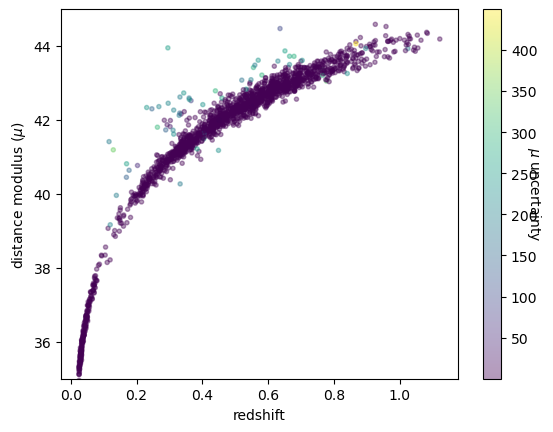

In [11]:
import pandas as pd  # Pandas is a useful package to read in data files and select portions of the data
from matplotlib import pyplot as plt
import numpy as np

df = pd.read_csv('data/DES-SN5YR_HD.csv') # Pandas reads into a "data frame (we'll call it df)"
zHELs = df['zHEL'].to_numpy() # You can keep using it in Pandas format, but just turning it into numpy arrays so it matches what you did above. 
zHDs = df['zHD'].to_numpy()
mu = df['MU'].to_numpy()
muerr = df['MUERR_FINAL'].to_numpy()
nSN = len(zHDs)
print(nSN)

hubblediagram=plt.scatter(zHDs,mu,marker='.',c=muerr,alpha=0.4)
plt.xlabel('redshift')
plt.ylabel('distance modulus ($\mu$)')
cbar=plt.colorbar(hubblediagram)
cbar.set_label('$\mu$ uncertainty', rotation=270)
plt.ylim(35,45)
plt.show()

# Warning, with this many data points it's going to take a long time to do the fit!  Test with a small grid first!  
# And consider adding interpolation to determine luminosity distances instead of doing this many integrals.

In [12]:
# To do this properly, you really should use the covariance matrix, rather than just the diagonal errors. 
# It's optional for this project, but here's how you construct the covariance matrix from the file provided.

df2 = pd.read_csv('data/STAT+SYS.txt.gz', skiprows = 1, delim_whitespace=True,comment='#',names=['COV'], compression='gzip')
cov1d=df2['COV'].to_numpy()
cov2d=cov1d.reshape(len(mu),len(mu))  
muerr_diag = np.diag(muerr)**2
cov2d=cov2d+muerr_diag
acov = np.linalg.inv(cov2d)



In [13]:
n = 10                        # Increase this for a finer grid
oms = np.linspace(0.2, 0.4, n)   # Array of matter densities
ols = np.linspace(0.6, 0.8, n)   # Array of cosmological constant values
was = np.linspace(-1, 1, n)  # Array of changes in equation of state
orrs = np.linspace(0.0, 0.1, n) # array of radiation densities
w0s = np.linspace(-0.9, -0.4, n)
chi2 = np.ones((n, n, n, n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values



# Calculate Chi2 for each model
for i, om in enumerate(oms):    # loop through matter densities                                   
        for j, ol in enumerate(ols):    # loop through cosmological constant densities
                for k, wa in enumerate(was):    # loop through changes in equation of state
                                for l, orr in enumerate(orrs):     # loop through radiation densities       
                                                for m, w0 in enumerate(w0s):                
                                                        mu_model = dist_mod_test(zHDs, om=om, wa=wa, ol=ol, orr=orr, w0=w0)                     # calculate the distance modulus vs redshift for that model 
                                                        mscr = np.sum((mu_model-mu)/muerr**2)/np.sum(1./muerr**2) # Calculate the vertical offset to apply
                                                        # mu_model_norm = mu_model-mscr  # Apply the vertical offset
                                                        delta = np.array([mu_model - mscr - mu]) 
                                                        chi2[i,j,k,l,m]  = np.sum(delta @ acov @ np.transpose(delta)) # Calculate the chi2 and save it in a matrix




                                                       

# Convert that to a likelihood and calculate the reduced chi2
likelihood = np.exp(-0.5 * (chi2-np.amin(chi2)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
chi2_reduced = chi2 / (len(mu)-1-5)                 # calculate the reduced chi^2, i.e. chi^2 per degree of freedom, where dof = number of data points minus number of parameters being fitted 

# Calculate the best fit values (where chi2 is minimum)
indbest = np.argmin(chi2)                 # Gives index of best fit but where the indices are just a single number
ibest   = np.unravel_index(indbest,[n,n,n,n,n]) # Converts the best fit index to the 5d version
print( 'Best fit values are (om,ol,wa,orr,w0)=(%.3f,%.3f,%.3f,%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]], was[ibest[2]], orrs[ibest[3]], w0s[ibest[4]] ) )
print( 'Reduced chi^2 for the best fit is %0.2f'%chi2_reduced[ibest[0],ibest[1],ibest[2],ibest[3],ibest[4]] )
#For a good fit, the reduced Chi^2 should be close to 1.

Best fit values are (om,ol,wa,orr,w0)=(0.222,0.600,-1.000,0.089,-0.900)
Reduced chi^2 for the best fit is 0.90


In [14]:
print(likelihood)

[[[[[3.85075921e-041 2.43692006e-038 1.37627331e-035 ...
     8.34430450e-023 1.69800009e-020 2.73064932e-018]
    [1.25807750e-034 4.41360388e-032 1.36892573e-029 ...
     3.64122502e-018 3.87331740e-016 3.23425572e-014]
    [6.69734176e-029 1.35322282e-026 2.39637958e-024 ...
     3.42674252e-014 1.98764136e-012 8.99313258e-011]
    ...
    [4.42270166e-010 9.00200739e-009 1.54982048e-007 ...
     1.17295345e-002 5.47659670e-002 1.94314919e-001]
    [5.88745646e-008 8.16687533e-007 9.52697149e-006 ...
     9.49577157e-002 2.91256792e-001 6.75947643e-001]
    [2.72126946e-006 2.62648162e-005 2.12023037e-004 ...
     3.10776738e-001 6.40737366e-001 9.95497766e-001]]

   [[1.63727521e-035 8.79582968e-033 4.09676166e-030 ...
     5.70556980e-018 7.69263447e-016 7.83676307e-014]
    [1.32190363e-029 3.84829115e-027 9.62796585e-025 ...
     5.33023987e-014 3.69492597e-012 1.92480961e-010]
    [1.91921280e-024 3.15093984e-022 4.40966758e-020 ...
     1.19762860e-010 4.45737403e-009 1.240304

In [15]:

marginliks = np.zeros((n,n))

for i, om in enumerate(oms):
    for j, ol in enumerate(ols):
        marginliks[i,j] = np.sum([np.sum([np.sum(likelihood[i,j,k,l,:]) for l, orr in enumerate(orrs)]) for k, wa in enumerate(was)])

# [np.sum(np.sum(np.sum(likelihood[i,j,k,l,:])))]

# np.sum(likelihood[i,j,k,l,:])

# np.sum([np.sum([np.sum(likelihood[1,2,3,4,:])][1,2,3,:])][1,2,:])

# [np.sum(likelihood[i,j,1,l,:]) for l ]

# marginliks = np.ones((n,n))
# print(marginliks)
# [np.sum([np.sum(likelihood[1,2,k,l,:]) for l, orr in enumerate(orrs)]) for k, wa in enumerate(was)]



In [16]:
np.sum(likelihood)

1398.1117567741946

In [17]:
marginliks

array([[34.55488869, 26.94441038, 20.31056036, 14.93055956, 10.73990802,
         7.55325848,  5.18187254,  3.45885328,  2.23971683,  1.40331926],
       [37.34010892, 30.00886607, 23.06821546, 17.09622007, 12.31832757,
         8.6625544 ,  5.94283914,  3.96909249,  2.57503717,  1.61869801],
       [38.16624966, 31.59290977, 24.99337491, 18.91240244, 13.77021886,
         9.72122717,  6.68133958,  4.46986635,  2.90462492,  1.82936863],
       [37.54835726, 31.71373081, 25.71962847, 19.97292983, 14.84490937,
        10.60309433,  7.32583076,  4.9166362 ,  3.20594251,  2.0267456 ],
       [36.08527825, 30.86628172, 25.43429338, 20.15241696, 15.31683953,
        11.15461082,  7.80172252,  5.26732982,  3.44640669,  2.1869168 ],
       [34.04227117, 29.42692436, 24.51410462, 19.67302178, 15.19146172,
        11.26848   ,  8.0199162 ,  5.48254825,  3.61223822,  2.30066859],
       [31.4137448 , 27.49834006, 23.15493221, 18.77047791, 14.65101995,
        11.00517411,  7.94709308,  5.5124846 

In [18]:
marginchi2=-2*np.log(marginliks)
print(marginchi2-np.amin(marginchi2))

[[0.19880514 0.69635148 1.26162129 1.87708304 2.53597017 3.2399451
  3.99357025 4.80202899 5.67120433 6.60622255]
 [0.04376711 0.48091747 1.00699178 1.60618844 2.26172682 2.96588393
  3.71952924 4.52682826 5.39217528 6.32065896]
 [0.         0.37803777 0.84668164 1.40426737 2.0388868  2.73527949
  3.48526621 4.2891862  5.15129468 6.07596142]
 [0.03264396 0.37040375 0.78939431 1.29514752 1.88858921 2.56161146
  3.30109009 4.09865402 4.95389097 5.8710405 ]
 [0.11213326 0.42457445 0.81170642 1.27725476 1.82599752 2.46019734
  3.17521413 3.9608561  4.80923892 5.71891782]
 [0.22869717 0.52008312 0.88540592 1.32540673 1.84243613 2.43988432
  3.12004727 3.88076321 4.71524804 5.61750367]
 [0.38941216 0.65565193 0.99948759 1.41933259 1.91488331 2.48717215
  3.13829079 3.86987232 4.68073209 5.56661738]
 [0.61466187 0.84424543 1.15961873 1.55642605 2.03215771 2.58530065
  3.21546769 3.92375764 4.71155342 5.57801428]
 [0.94125557 1.11151054 1.38374388 1.7480079  2.19829834 2.73088725
  3.34318633 

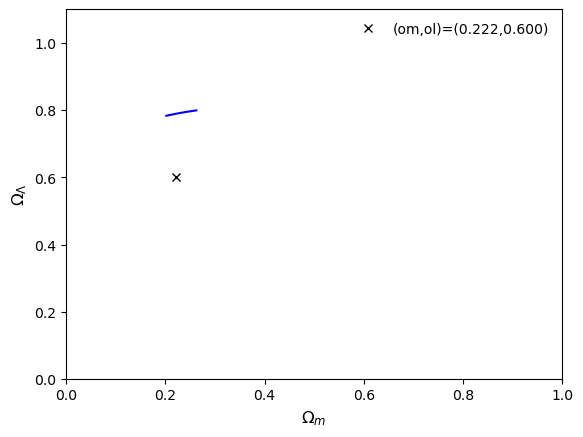

In [21]:
plt.contour(oms, ols, np.transpose(marginchi2 - np.amin(marginchi2)),cmap="winter", **{'levels':[5.89,11.31,18.21]}) #
# 5.89,11.31,18.21
# 2.3,6.18,11.83
plt.plot(oms[ibest[0]], ols[ibest[1]],'x',color='black',label='(om,ol)=(%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]]) )
plt.xlabel("$\Omega_m$", fontsize=12)
# plt.xlim(min(oms),max(oms))
plt.xlim(0,1)
plt.ylabel("$\Omega_\Lambda$", fontsize=12)
# plt.ylim(min(ols),max(ols)+0.1)
plt.ylim(0,1.1)
# plt.plot([oms[0],oms[1]], [ols[0],ols[1]],'-',color='black',label='Step size indicator' ) # Delete this line after making step size smaller!
plt.legend(frameon=False)
#plt.savefig('plots/contours.png', bbox_inches="tight", transparent=True)
plt.show()
plt.close()

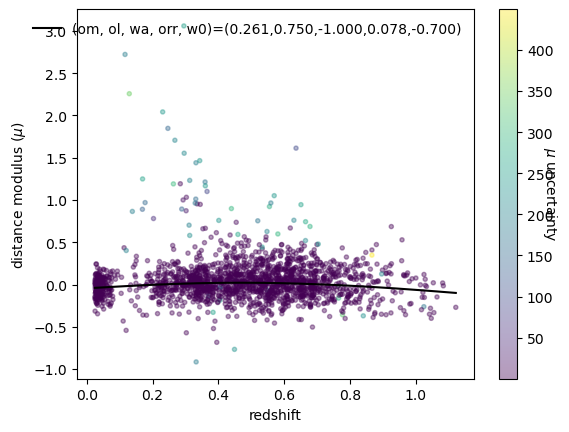

In [ ]:
mu_BestFit = dist_mod_test(zHDs,om=oms[ibest[0]], ol=ols[ibest[1]], wa=was[ibest[2]], orr=orrs[ibest[3]], w0=w0s[ibest[4]])
mscr_BestFit = np.sum((mu_BestFit-mu)/muerr**2)/np.sum(1./muerr**2)
mu_BestFit=mu_BestFit-mscr_BestFit

empty = dist_mod_test(zHDs,om=0.0, ol=0.0, orr=0.0)
mscrempty = np.sum((empty-mu)/muerr**2)/np.sum(1./muerr**2)
empty=empty-mscrempty

hubblediagram=plt.scatter(zHDs,mu-empty,marker='.',c=muerr,alpha=0.4)
plt.xlabel('redshift')
plt.ylabel('distance modulus ($\mu$)')
cbar=plt.colorbar(hubblediagram)
cbar.set_label('$\mu$ uncertainty', rotation=270)
# plt.ylim(35,45)

plt.plot(np.sort(zHDs),mu_BestFit[np.argsort(zHDs)] - empty[np.argsort(zHDs)],'-',color='black',label='(om, ol, wa, orr, w0)=(%.3f,%.3f,%.3f,%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]], was[ibest[2]], orrs[ibest[3]], w0s[ibest[4]] ))
# plt.axhline(y=0.0,ls=':',color='black')
plt.legend(frameon=False)
plt.show()